# **Q1 What affects Cafe Insomnia's hourly sales (in AUD) ?**

In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import sqlite3
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import ttest_ind # Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
from scipy.stats import pearsonr # Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

In [11]:
conn = sqlite3.connect('cafe_insomnia.sqlite')
query = '''SELECT t.id, t.date, t.day_of_week, t.days_after_open, t.hours_after_open, t.quantity, d.name, d.unit_price 
           FROM ci_transaction t 
           JOIN drink d 
           ON t.drink_id = d.id;'''
TD = pd.read_sql(query, conn)
TD['sale_transactions'] = TD['quantity'] * TD['unit_price']
print(TD.isnull())
TD.info()
TD.head()

          id   date  day_of_week  days_after_open  hours_after_open  quantity  \
0      False  False        False            False             False     False   
1      False  False        False            False             False     False   
2      False  False        False            False             False     False   
3      False  False        False            False             False     False   
4      False  False        False            False             False     False   
...      ...    ...          ...              ...               ...       ...   
27709  False  False        False            False             False     False   
27710  False  False        False            False             False     False   
27711  False  False        False            False             False     False   
27712  False  False        False            False             False     False   
27713  False  False        False            False             False     False   

        name  unit_price  s

,id,date,day_of_week,days_after_open,hours_after_open,quantity,name,unit_price,sale_transactions
0,0,2019-07-22,Mon,0,0,1,Flat White (L),4.9,4.9
1,1,2019-07-22,Mon,0,0,1,Flat White (L),4.9,4.9
2,2,2019-07-22,Mon,0,0,1,Macchiato,3.8,3.8
3,3,2019-07-22,Mon,0,0,1,Macchiato,3.8,3.8
4,4,2019-07-22,Mon,0,0,1,Flat White (L),4.9,4.9


In [12]:
days = TD['date'].nunique()
weeks = int(days/7)
hours = TD['hours_after_open'].nunique()
print('There are {} days and {} weeks in total, and {} hours per day (19:00-1:00) for the data collected from Cafe Insomnia.'.format(days, weeks, hours))

There are 154 days and 22 weeks in total, and 6 hours per day (19:00-1:00) for the data collected from Cafe Insomnia.


## 1.1 Days after open

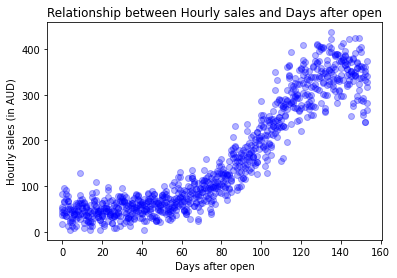

In [13]:
# 1.1 Days after open ------------------------------------------------------------------
hs_d = TD.groupby([TD['days_after_open'],TD['hours_after_open']]).sum().reset_index()[['days_after_open', 'sale_transactions']].to_numpy()

# Graph 1.1.1 Relationship between Hourly sales and Days after open
plt.scatter(hs_d[:,0], hs_d[:,1], c='blue', alpha=0.3)
plt.xlabel("Days after open")
plt.ylabel("Hourly sales (in AUD)")
plt.title("Relationship between Hourly sales and Days after open")
plt.savefig('1.1 Days after open.pdf')
plt.show()
# Nonlinearity, so considering using polynomial regression

In [14]:
# Creating higher degrees
x1 = hs_d[:,0].reshape(-1,1)
x2 = pow(x1,2)
x3 = pow(x1,3)
x4 = pow(x1,4)
x5 = pow(x1,5)
x6 = pow(x1,6)
x7 = pow(x1,7)
x8 = pow(x1,8)
x9 = pow(x1,9)
x10 = pow(x1,10)

Xd = np.hstack((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10)) # Polynomial terms - features
yd = hs_d[:,1] # Hourly sales 154days * 6hours - targets

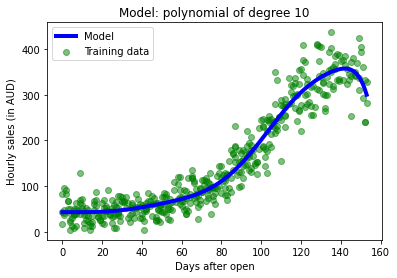

In [15]:
# Train test split(50% training, 25% validation, 25% test)
Xd_tv, Xd_test, yd_tv, yd_test = tts(Xd, yd, test_size=0.25, random_state=1)
Xd_train, Xd_val, yd_train, yd_val = tts(Xd_tv, yd_tv, test_size=1/3, random_state=1)

lr = LinearRegression()
lr.fit(Xd_train, yd_train)

# Graph 1.1.2 Model: polynomial of degree 10
plt.plot(Xd[:,0], lr.predict(Xd), color = 'blue', linewidth=4, label = 'Model')
plt.scatter(Xd_train[:,0], yd_train, color='green', alpha=0.5, label='Training data')
plt.legend()
plt.xlabel("Days after open")
plt.ylabel("Hourly sales (in AUD)")
plt.title('Model: polynomial of degree 10')
plt.savefig('1.2 Polynomial of degree 10.pdf')
plt.show()

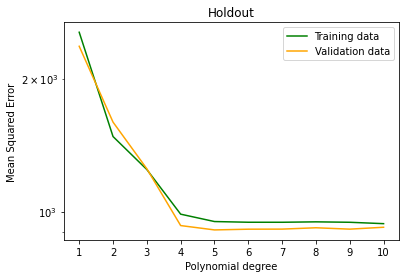

In [16]:
# Holdout validation
mse_train = []
mse_val = []

max_deg = 10
degrees = range(1, max_deg+1)

for deg in degrees:
    lr.fit(Xd_train[:, :deg], yd_train)
    pred_train = lr.predict(Xd_train[:, :deg])
    pred_vali = lr.predict(Xd_val[:, :deg])
    mse_train.append(mse(pred_train, yd_train))
    mse_val.append(mse(pred_vali, yd_val))
    
# Graph 1.1.3 Holdout for polynomial degrees
plt.plot(range(1,11), mse_train, color = 'green', label = 'Training data')
plt.plot(range(1,11), mse_val, color = 'orange', label = 'Validation data')
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')
plt.title('Holdout')
plt.xticks(degrees)
plt.yscale('log')
plt.legend()
plt.savefig('1.3 Hold out.pdf')
plt.show()

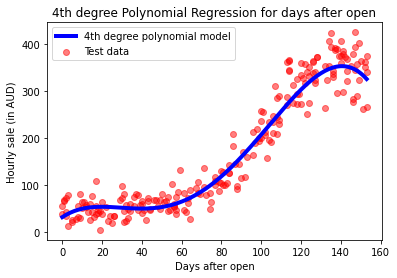

Test mse: 1002.3495

The beta 0 (intercept) of this model is 31.15
The beta 1 is 2.79116
The beta 2 is -0.11568
The beta 3 is 0.00168
The beta 4 is -0.00001


In [17]:
# Take 4th degree polynomial for days after open
degree = 4
lr.fit(Xd_tv[:, :degree], yd_tv)

# Graph 1.1.4 4th degree Polynomial Regression for days after open
plt.plot(Xd[:,0], lr.predict(Xd[:, :degree]), color='blue', linewidth=4, label='4th degree polynomial model')
plt.scatter(Xd_test[:,0], yd_test, c='red', alpha=0.5, label='Test data')
plt.xlabel('Days after open')
plt.ylabel('Hourly sale (in AUD)')
plt.title('4th degree Polynomial Regression for days after open')
plt.legend()
plt.savefig('1.4 4th polynomial.pdf')
plt.show()

pred_test = lr.predict(Xd_test[:, :degree])
mse_test = mse(pred_test, yd_test)
print('Test mse: {:.4f}\n'.format(mse_test))
print('The beta 0 (intercept) of this model is {:.2f}'.format(lr.intercept_))
for i in range(len(lr.coef_)):
    print('The beta {} is {:.5f}'.format(i+1, lr.coef_[i]))

# X and some values for multi
poly_x = Xd[:, :4]
poly_pred = lr.predict(Xd[:, :4]).reshape(-1,1)
poly_r2 = lr.score(Xd[:, :4], yd)
poly_ar2 = 1 - (1-poly_r2)*(len(yd)-1)/(len(yd)-Xd.shape[1]-1)

$\hat{y}=31.15+2.79116x-0.11568x^2+0.00168x^3-0.00001x^4$

## 1.2 Day of the week & Hour of the day

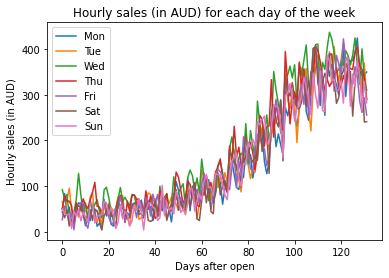

In [18]:
# 1.2 Day of the week ------------------------------------------------------------------
hoursales = TD.groupby([TD['days_after_open'],TD['hours_after_open']]).sum()['sale_transactions'].to_numpy().reshape(days,6)

DOW = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
nDOW = [0, 1, 2, 3, 4, 5, 6]

mon = np.zeros([weeks,hours])
tue = np.zeros([weeks,hours])
wed = np.zeros([weeks,hours])
thu = np.zeros([weeks,hours])
fri = np.zeros([weeks,hours])
sat = np.zeros([weeks,hours])
sun = np.zeros([weeks,hours])
# Seperate the hoursales to each weekday
for i in range(weeks):
    mon[i,:] = hoursales[7*i+0,:]
    tue[i,:] = hoursales[7*i+1,:]
    wed[i,:] = hoursales[7*i+2,:]
    thu[i,:] = hoursales[7*i+3,:]
    fri[i,:] = hoursales[7*i+4,:]
    sat[i,:] = hoursales[7*i+5,:]
    sun[i,:] = hoursales[7*i+6,:]
    
mon_avg = np.mean(mon, axis=0)
tue_avg = np.mean(tue, axis=0)
wed_avg = np.mean(wed, axis=0)
thu_avg = np.mean(thu, axis=0)
fri_avg = np.mean(fri, axis=0)
sat_avg = np.mean(sat, axis=0)
sun_avg = np.mean(sun, axis=0)

xmon = np.linspace(0.6, 1.4, 6)
xtue = np.linspace(1.6, 2.4, 6)
xwed = np.linspace(2.6, 3.4, 6)
xthu = np.linspace(3.6, 4.4, 6)
xfri = np.linspace(4.6, 5.4, 6)
xsat = np.linspace(5.6, 6.4, 6)
xsun = np.linspace(6.6, 7.4, 6)##

#Graph 1.2.1 Line graph for hourly sales for each weekday
weekday = [mon.reshape(-1,1), tue.reshape(-1,1), wed.reshape(-1,1), thu.reshape(-1,1), fri.reshape(-1,1), sat.reshape(-1,1), sun.reshape(-1,1)]
DOW = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
days_ao = range(weeks*hours)
for i in range(7):
    plt.plot(days_ao, weekday[i], label=DOW[i])
plt.legend()
plt.xlabel('Days after open')
plt.ylabel('Hourly sales (in AUD)')
plt.title('Hourly sales (in AUD) for each day of the week')
plt.savefig('2.1 hourly sales weekdays.pdf')
plt.show()


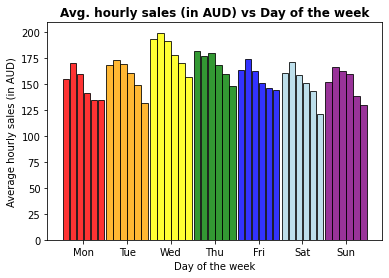

In [19]:
#Graph 1.2.2 Avg. hourly sales (in AUD) vs Day of the week
plt.bar(xmon, mon_avg, width=0.15, color='red', alpha=0.8, edgecolor='black')
plt.bar(xtue, tue_avg, width=0.15, color='orange', alpha=0.8, edgecolor='black')
plt.bar(xwed, wed_avg, width=0.15, color='yellow', alpha=0.8, edgecolor='black')
plt.bar(xthu, thu_avg, width=0.15, color='green', alpha=0.8, edgecolor='black')
plt.bar(xfri, fri_avg, width=0.15, color='blue', alpha=0.8, edgecolor='black')
plt.bar(xsat, sat_avg, width=0.15, color='lightblue', alpha=0.8, edgecolor='black')
plt.bar(xsun, sun_avg, width=0.15, color='purple', alpha=0.8, edgecolor='black')
plt.xticks([1,2,3,4,5,6,7], DOW)
plt.xlabel('Day of the week')
plt.ylabel('Average hourly sales (in AUD)')
plt.title('Avg. hourly sales (in AUD) vs Day of the week', fontweight="bold")
plt.savefig('2.2 sales-weekday.pdf')
plt.show()

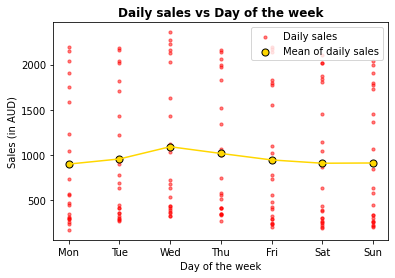

In [20]:
# Average sales from Mon-Sun.
AVGS_DOW = [] 
for i in range(7):
    avg = TD[TD['day_of_week']==DOW[i]]['sale_transactions'].sum() / weeks
    AVGS_DOW.append(round(avg,2))

sale_perD = TD[['date', 'day_of_week', 'sale_transactions']].groupby('date').sum().to_numpy()

mon = np.zeros(22)
tue = np.zeros(22)
wed = np.zeros(22)
thu = np.zeros(22)
fri = np.zeros(22)
sat = np.zeros(22)
sun = np.zeros(22)
xxmon = []
xxtue = []
xxwed = []
xxthu = []
xxfri = []
xxsat = []
xxsun = []

# Sales for Mon-Sun in 22 weeks
for i in range(22):
    mon[i] = (sale_perD[i*7 + 0])
    tue[i] = (sale_perD[i*7 + 1])
    wed[i] = (sale_perD[i*7 + 2])
    thu[i] = (sale_perD[i*7 + 3])
    fri[i] = (sale_perD[i*7 + 4])
    sat[i] = (sale_perD[i*7 + 5])
    sun[i] = (sale_perD[i*7 + 6])
    xxmon.append(0)
    xxtue.append(1)
    xxwed.append(2)
    xxthu.append(3)
    xxfri.append(4)
    xxsat.append(5)
    xxsun.append(6)

# Graph 1.2.3 Scatter plot & Line graph for the daily sales in 22 weeks
plt.scatter(xxmon, mon, marker='o', s=10, c='red', alpha=0.5, label='Daily sales')
plt.scatter(xxtue, tue, marker='o', s=10, c='red', alpha=0.5)
plt.scatter(xxwed, wed, marker='o', s=10, c='red', alpha=0.5)
plt.scatter(xxthu, thu, marker='o', s=10, c='red', alpha=0.5)
plt.scatter(xxfri, fri, marker='o', s=10, c='red', alpha=0.5)
plt.scatter(xxsat, sat, marker='o', s=10, c='red', alpha=0.5)
plt.scatter(xxsun, sun, marker='o', s=10, c='red', alpha=0.5)

plt.scatter(nDOW, AVGS_DOW, marker='o', s=50, c='gold', edgecolors='black', label='Mean of daily sales')
plt.plot(nDOW, AVGS_DOW, '-', c='gold')
plt.xticks(nDOW,DOW)
plt.xlabel('Day of the week')
plt.ylabel('Sales (in AUD)')
plt.title('Daily sales vs Day of the week', fontweight="bold")
plt.legend(loc=1)
plt.savefig('2.3 sales_avg-day_week.pdf')
plt.show()

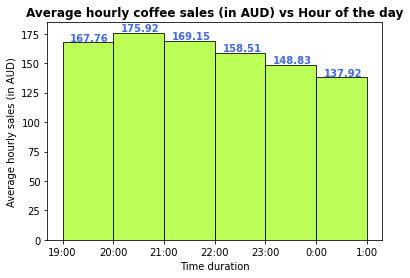

In [21]:
# 1.2 Hour of the day ------------------------------------------------------------------

# Average sales from 19:00 to 1:00.
hour0 = hoursales[:,0]
hour1 = hoursales[:,1]
hour2 = hoursales[:,2]
hour3 = hoursales[:,3]
hour4 = hoursales[:,4]
hour5 = hoursales[:,5]
AVGS_HOD = []
for i in range(hours):
    AVGS_HOD.append(round(hoursales[:,i].mean(),2))
HOD = [1, 2, 3, 4, 5, 6]
times = ['19:00', '20:00', '21:00', '22:00', '23:00', '0:00', '1:00']

# Graph 1.2.4 Bar chart Avg. hourly coffee sales (in AUD) vs Hour of the day
plt.bar(HOD, AVGS_HOD, width=1, color='greenyellow', alpha=0.8, edgecolor='black')
for i in range(6):
    plt.text(i+0.65, AVGS_HOD[i]+1.4, AVGS_HOD[i], color='royalblue', weight='bold')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], times)
plt.xlabel('Time duration')
plt.ylabel('Average hourly sales (in AUD)')
plt.title('Average hourly coffee sales (in AUD) vs Hour of the day', fontweight="bold")
plt.savefig('2.4 sales-hour_day.pdf')
plt.show()

In [22]:
# Simple regression: Day of the week & Hourly sales

In [23]:
dum = pd.get_dummies(TD['day_of_week'], drop_first=True)
dum = dum[['Mon', 'Tue', 'Wed', 'Thu','Sat', 'Sun']]
dum_day = ['Mon', 'Tue', 'Wed', 'Thu','Sat', 'Sun']
TDdum = pd.concat([TD, dum], axis=1)
X = TDdum.groupby([TDdum['days_after_open'],TDdum['hours_after_open']]).sum()[['sale_transactions', 'Mon', 'Tue', 'Wed', 'Thu','Sat', 'Sun']].to_numpy()
# Clean the dummies
for i in range(X.shape[0]):
    for j in range(1, X.shape[1]):
        if X[i,j] != 0:
            X[i,j] = 1
# 924 hourly sales
hs = X[:,0] #Y
day_dum = X[:,1:] #Xi

lr = LinearRegression()
lr.fit(day_dum, hs)
print('The intercept is {:.2f}'.format(lr.intercept_))
print('Which means the base case Friday\'s estimated hourly sale is $156.99 \n' )
for i in range(6):
    print('The coefficient of {} is {:.2f}'.format(dum_day[i], lr.coef_[i]))
    
print('\nThe MSE of this estimated model is {:.2f}'.format(mse(hs, lr.predict(day_dum))))

The intercept is 156.99
Which means the base case Friday's estimated hourly sale is $156.99 

The coefficient of Mon is -7.68
The coefficient of Tue is 1.80
The coefficient of Wed is 24.44
The coefficient of Thu is 12.01
The coefficient of Sat is -6.10
The coefficient of Sun is -5.65

The MSE of this estimated model is 14814.67


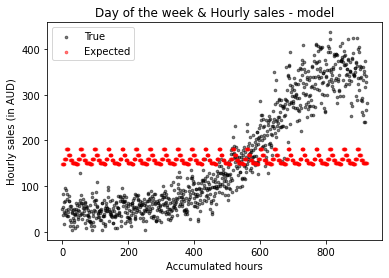

In [24]:
# Graph 1.2.5 Day of the week & Hourly sales - model
plt.scatter(range(924), hs, c='black', s=7, alpha=0.5, label='True')
plt.scatter(range(924), lr.predict(day_dum), c='red', s=7, alpha=0.5, label='Expected')
plt.legend()
plt.xlabel('Accumulated hours')
plt.ylabel('Hourly sales (in AUD)')
plt.title('Day of the week & Hourly sales - model')
plt.savefig('2.5 Day of the week model.pdf')
plt.show()

$\hat{y}=156.99 -7.68Mon + 1.80Tue + 24.44Wed + 12.01Thu -6.10Sat -5.65Sun $

In [25]:
# Simple regression: Hour of the day & Hourly sales

In [26]:
dumm = pd.get_dummies(TD['hours_after_open'], drop_first=True)
TDdumm = pd.concat([TD, dumm], axis=1)
XX = TDdumm.groupby([TDdumm['days_after_open'],TDdumm['hours_after_open']]).sum()[['sale_transactions', 1, 2, 3, 4, 5]].to_numpy()
#Clean the dummies
for i in range(XX.shape[0]):
    for j in range(1, XX.shape[1]):
        if XX[i,j] != 0:
            XX[i,j] = 1

# 924 hourly sales
hs = XX[:,0] #Y
hour_dum = XX[:,1:] #Xi
hhh = ['the second hour', 'the third hour', 'the fourth hour', 'the fifth hour', 'the sixth hour']
lr = LinearRegression()
lr.fit(hour_dum, hs)
print('The intercept is {:.2f}\n'.format(lr.intercept_))
for i in range(5):
    print('The coefficient of {} is {:.2f}'.format(hhh[i], lr.coef_[i]))
    
print('\nThe MSE of this estimated model is {:.2f}'.format(mse(hs, lr.predict(hour_dum))))

The intercept is 167.76

The coefficient of the second hour is 8.16
The coefficient of the third hour is 1.39
The coefficient of the fourth hour is -9.25
The coefficient of the fifth hour is -18.92
The coefficient of the sixth hour is -29.84

The MSE of this estimated model is 14763.65


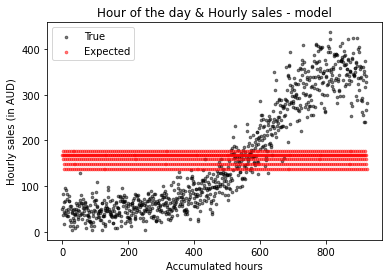

In [27]:
# Graph 1.2.6 Hour of the day & Hourly sales - model
plt.scatter(range(924), hs, c='black', s=7, alpha=0.5, label='True')
plt.scatter(range(924), lr.predict(hour_dum), c='red', s=7, alpha=0.5, label='Expected')
plt.legend()
plt.xlabel('Accumulated hours')
plt.ylabel('Hourly sales (in AUD)')
plt.title('Hour of the day & Hourly sales - model')
plt.savefig('2.6 Hour of the day model.pdf')
plt.show()

$\hat{y}=167.76 + 8.16 Hour_1 + 1.39 Hour_2 - 9.25 Hour_3 -18.92 Hour_4 -29.84 Hour_5$

## 1.3 Raining & Distance

In [28]:
# 1.3 Raining & Distance ------------------------------------------------------------------
sales = pd.read_sql("Select * From ci_transaction;",conn)
area = pd.read_sql("Select * From study_area;",conn)
coffee = pd.read_sql("Select * From drink;",conn)

sales.head()

,id,date,days_after_open,day_of_week,hours_after_open,drink_id,quantity,raining,study_area_id
0,0,2019-07-22,0,Mon,0,5,1,No,3
1,1,2019-07-22,0,Mon,0,5,1,No,1
2,2,2019-07-22,0,Mon,0,2,1,No,5
3,3,2019-07-22,0,Mon,0,2,1,No,6
4,4,2019-07-22,0,Mon,0,5,1,No,5


In [29]:
area.head()

,id,name,dist_to_cafe
0,0,Fisher Library (F03),70
1,1,Law Library (F10),84
2,2,The Quarter (A16),400
3,3,Abercrombie (H70),700
4,4,Brennan MacCallum (A18),350


In [30]:
coffee.head()

,id,name,unit_price
0,0,Espresso,3.5
1,1,Ristretto,3.3
2,2,Macchiato,3.8
3,3,Long Black (L),4.0
4,4,Long Black (S),3.8


In [31]:
coffee['drink_id']=coffee['id']
area['study_area_id']=area['id']

coffee = coffee.drop(['id'], axis=1)
coffee

,name,unit_price,drink_id
0,Espresso,3.5,0
1,Ristretto,3.3,1
2,Macchiato,3.8,2
3,Long Black (L),4.0,3
4,Long Black (S),3.8,4
5,Flat White (L),4.9,5
6,Flat White (S),4.0,6
7,Latte (L),4.9,7
8,Latte (S),4.0,8
9,Cappuccino (L),4.9,9


In [32]:
area = area.drop(['id'], axis=1)
area

,name,dist_to_cafe,study_area_id
0,Fisher Library (F03),70,0
1,Law Library (F10),84,1
2,The Quarter (A16),400,2
3,Abercrombie (H70),700,3
4,Brennan MacCallum (A18),350,4
5,Carslaw (F07),150,5
6,Peter Nicol Russell (PNR),950,6


In [33]:
# Merge tables
sales1 = pd.merge(sales, coffee, on='drink_id')
sales1.head()

,id,date,days_after_open,day_of_week,hours_after_open,drink_id,quantity,raining,study_area_id,name,unit_price
0,0,2019-07-22,0,Mon,0,5,1,No,3,Flat White (L),4.9
1,1,2019-07-22,0,Mon,0,5,1,No,1,Flat White (L),4.9
2,4,2019-07-22,0,Mon,0,5,1,No,5,Flat White (L),4.9
3,7,2019-07-22,0,Mon,0,5,1,No,4,Flat White (L),4.9
4,19,2019-07-22,0,Mon,1,5,2,No,0,Flat White (L),4.9


In [34]:
sales2 = pd.merge(sales1, area, on='study_area_id')
sales2['sale'] = sales2['quantity'] * sales2['unit_price']
sales2 = sales2.sort_values(by="id", ascending=True)
sales2 = sales2.reset_index(drop=True)
sales2.head(20)

,id,date,days_after_open,day_of_week,hours_after_open,drink_id,quantity,raining,study_area_id,name_x,unit_price,name_y,dist_to_cafe,sale
0,0,2019-07-22,0,Mon,0,5,1,No,3,Flat White (L),4.9,Abercrombie (H70),700,4.9
1,1,2019-07-22,0,Mon,0,5,1,No,1,Flat White (L),4.9,Law Library (F10),84,4.9
2,2,2019-07-22,0,Mon,0,2,1,No,5,Macchiato,3.8,Carslaw (F07),150,3.8
3,3,2019-07-22,0,Mon,0,2,1,No,6,Macchiato,3.8,Peter Nicol Russell (PNR),950,3.8
4,4,2019-07-22,0,Mon,0,5,1,No,5,Flat White (L),4.9,Carslaw (F07),150,4.9
5,5,2019-07-22,0,Mon,0,9,1,No,0,Cappuccino (L),4.9,Fisher Library (F03),70,4.9
6,6,2019-07-22,0,Mon,0,16,1,No,5,Hot Chocolate (S),3.8,Carslaw (F07),150,3.8
7,7,2019-07-22,0,Mon,0,5,1,No,4,Flat White (L),4.9,Brennan MacCallum (A18),350,4.9
8,8,2019-07-22,0,Mon,0,11,1,No,5,Chai Latte (L),4.4,Carslaw (F07),150,4.4
9,9,2019-07-22,0,Mon,0,9,1,No,1,Cappuccino (L),4.9,Law Library (F10),84,4.9


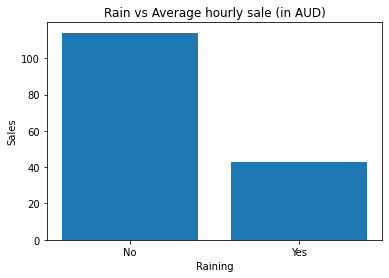

In [35]:
rain = sales2.groupby('raining').sum()['sale']/(154*6)

# Graph 1.3.1 Raining vs Average hourly sale (in AUD)
plt.bar(rain.index,rain.values)
plt.title("Rain vs Average hourly sale (in AUD)")
plt.xlabel('Raining')
plt.ylabel('Sales')
plt.savefig('3.1 rain.pdf')
plt.show()

In [36]:
# Using t-test to identify raining impact (After filling NA)
rain_hourly_sale = sales2.groupby(['days_after_open','hours_after_open','raining'])['sale'].sum()
rain_hourly_sale = rain_hourly_sale.to_frame()
print(rain_hourly_sale.groupby('raining').mean()['sale'])

rain_yes = sales2[sales2['raining'] == 'Yes']['sale']
rain_no = sales2[sales2['raining'] == 'No']['sale']
s_stat , pvalue = ttest_ind(rain_yes,rain_no)
print('''\nThe test statistic is {:.4f}, and the p-value is {:.4f}, so 'p-value < 0.05' is {}. '''.format(s_stat , pvalue, pvalue<0.05))

raining
No     168.622080
Yes    131.610702
Name: sale, dtype: float64

The test statistic is -0.4262, and the p-value is 0.6700, so 'p-value < 0.05' is False. 


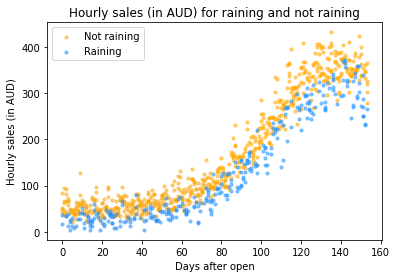

In [37]:
rrr = rain_hourly_sale.reset_index()

rain_hs = rrr[rrr['raining']=='Yes'][['days_after_open' ,'sale']].to_numpy()
nrain_hs = rrr[rrr['raining']=='No'][['days_after_open' ,'sale']].to_numpy()

# Graph 1.3.2 Hourly sales (in AUD) for raining and not raining
plt.scatter(nrain_hs[:,0],nrain_hs[:,1], c='orange', s=10, alpha=0.5, label='Not raining')
plt.scatter(rain_hs[:,0],rain_hs[:,1], c='dodgerblue', s=10, alpha=0.5, label='Raining')
plt.xlabel('Days after open')
plt.ylabel('Hourly sales (in AUD)')
plt.title('Hourly sales (in AUD) for raining and not raining')
plt.legend()
plt.savefig('3.2 raining_scatter.pdf')
plt.show()

In [38]:
# Simple regression for raining or not raining
rrr_d = pd.get_dummies(rrr['raining'], drop_first=True).to_numpy() # Dummy variable for raining
hs = XX[:,0].reshape(-1,1) #From 1.2 regression

lr.fit(rrr_d, hs) # Base case is not raining (dummy=0)
print('For this simple regression model, the intercept is {:.2f} and coefficient is {:.2f}\n'.format(lr.intercept_[0], lr.coef_[0][0]))
print('It means the estimated hourly sale during raining is $37.62 lower than not raining.')

For this simple regression model, the intercept is 171.86 and coefficient is -37.62

It means the estimated hourly sale during raining is $37.62 lower than not raining.


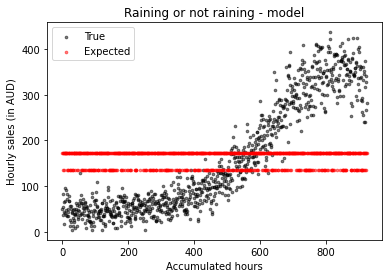

In [39]:
# Graph 1.3.3 Raining or not raining - model
plt.scatter(range(924), hs, c='black', s=7, alpha=0.5, label='True')
plt.scatter(range(924), lr.predict(rrr_d), c='red', s=7, alpha=0.5, label='Expected')
plt.legend()
plt.xlabel('Accumulated hours')
plt.ylabel('Hourly sales (in AUD)')
plt.title('Raining or not raining - model')
plt.savefig('3.3 Raining or not raining model.pdf')
plt.show()

$\hat{y}=171.86-37.62 Raining$

dist_to_cafe
70     261.690909
84     237.194156
150    163.584416
350     68.511039
400     66.542857
700     71.272078
950     71.077273
Name: sale, dtype: float64


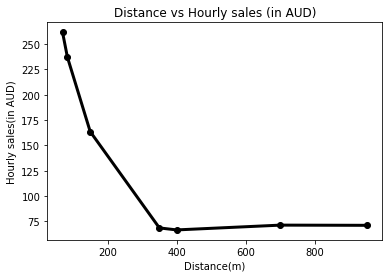

In [40]:
# Calculate distance of study area to cafe
distance = sales2.groupby('dist_to_cafe').sum()['sale']
dist = distance/154
print(dist)

# Graph 1.3.4 Distance vs Hourly sales (in AUD)
plt.plot(dist, '-o', linewidth=3, color='black')
plt.xlabel('Distance(m)')
plt.ylabel('Hourly sales(in AUD)')
plt.title("Distance vs Hourly sales (in AUD)")
plt.savefig('3.4 Distance.pdf')
plt.show()

In [41]:
# The relationship between distance to cafe and hourly sales
# Calculate correlation
np.corrcoef(dist, dist.index)

array([[ 1.        , -0.76839585],
       [-0.76839585,  1.        ]])

In [42]:
# H0: no correlation = 0 H1: has correl != 0
# Test on correlation
correlation, pvalue = pearsonr(distance, distance.index)
print('''The correlation between distance and houly sale is {:.4f}, and the p-value is {:.4f}, so 'p-value < 0.05' is {}.'''.format(correlation, pvalue, pvalue<0.05))

The correlation between distance and houly sale is -0.7684, and the p-value is 0.0436, so 'p-value < 0.05' is True.


In [43]:
area_hourly_distance = sales2.groupby(['days_after_open','hours_after_open','day_of_week','raining'])['dist_to_cafe'].mean()
area_hourly_distance = area_hourly_distance.reset_index()
area_hourly_distance.head()

,days_after_open,hours_after_open,day_of_week,raining,dist_to_cafe
0,0,0,Mon,No,264.363636
1,0,1,Mon,No,246.769231
2,0,2,Mon,Yes,77.000000
3,0,3,Mon,No,471.000000
4,0,4,Mon,Yes,101.333333


In [44]:
# Count hourly quantity of purchase
quantity_hourly = sales2.groupby(['days_after_open','hours_after_open'])['quantity'].count()
quantity_hourly = quantity_hourly.reset_index()
quantity_hourly.head()

,days_after_open,hours_after_open,quantity
0,0,0,11
1,0,1,13
2,0,2,6
3,0,3,8
4,0,4,3


In [45]:
# Merge datasets
data_set = pd.merge(area_hourly_distance, quantity_hourly, on =['days_after_open','hours_after_open'])
data_set = pd.merge(data_set, rain_hourly_sale, on = ['days_after_open','hours_after_open'])
data_set.head()

,days_after_open,hours_after_open,day_of_week,raining,dist_to_cafe,quantity,sale
0,0,0,Mon,No,264.363636,11,49.0
1,0,1,Mon,No,246.769231,13,83.6
2,0,2,Mon,Yes,77.000000,6,37.3
3,0,3,Mon,No,471.000000,8,50.6
4,0,4,Mon,Yes,101.333333,3,16.1


In [46]:
# Location and Raining
print(sales2.query("raining == 'Yes'")['name_y'].value_counts())
print('')
print(sales2.query("raining == 'No'")['name_y'].value_counts())
print('')
LR = pd.crosstab(values = sales2['sale'], index = sales2['name_y'], columns = sales2['raining'], aggfunc = 'sum')
print(LR)

Fisher Library (F03)    3637
Law Library (F10)       3003
Carslaw (F07)            763
Name: name_y, dtype: int64

Carslaw (F07)                3965
Law Library (F10)            3914
Fisher Library (F03)         3907
Abercrombie (H70)            2024
Peter Nicol Russell (PNR)    2009
Brennan MacCallum (A18)      2003
The Quarter (A16)            1946
Name: name_y, dtype: int64

raining                         No      Yes
name_y                                     
Abercrombie (H70)          10975.9      NaN
Brennan MacCallum (A18)    10550.7      NaN
Carslaw (F07)              21102.1   4089.9
Fisher Library (F03)       20722.8  19577.6
Law Library (F10)          20843.8  15684.1
Peter Nicol Russell (PNR)  10945.9      NaN
The Quarter (A16)          10247.6      NaN


In [47]:
Law = sales2.query("name_y == 'Law Library (F10)'")
LL = Law.groupby(['days_after_open', 'hours_after_open','raining','day_of_week'])['sale'].sum().reset_index()
LL.groupby('raining')['sale'].mean()

raining
No     34.797663
Yes    54.083103
Name: sale, dtype: float64

In [48]:
# T test
LL_rain = LL.query("raining == 'Yes'")['sale']
LL_norain = LL.query("raining == 'No'")['sale']
s_stat , pvalue = ttest_ind(LL_rain, LL_norain)
print('''The test statistic is {:.4f}, and the p-value is {:.4f}, so 'p-value < 0.05' is {}.'''.format(s_stat , pvalue , pvalue<0.05))

The test statistic is 7.8148, and the p-value is 0.0000, so 'p-value < 0.05' is True.


# **Q2 Can a model be built to predict hourly sales (in AUD) ?**

In [49]:
# Preparation for independent variables and dependent variable
print(poly_x.shape)
print(day_dum.shape)
print(hour_dum.shape)
print(rrr_d.shape)
X = np.hstack((poly_x, day_dum, hour_dum, rrr_d))
print('\nFeatures:')
print(X.shape)
y = hs
print('\nTargets:')
print(y.shape)

(924, 4)
(924, 6)
(924, 5)
(924, 1)

Features:
(924, 16)

Targets:
(924, 1)


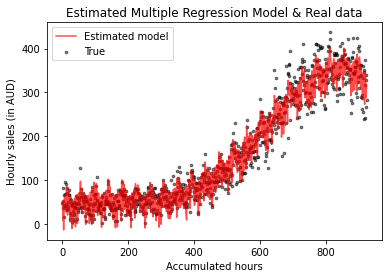

In [50]:
lr.fit(X, y)
# Graph 2.1 Estimated Multiple Regression Model using whole dataset
plt.scatter(range(924), hs, c='black', s=7, alpha=0.5, label='True')
plt.plot(range(924), lr.predict(X), color='red', alpha=0.7, label='Estimated model')
plt.xlabel('Accumulated hours')
plt.ylabel('Hourly sales (in AUD)')
plt.title('Estimated Multiple Regression Model & Real data')
plt.legend()
plt.savefig('4.1 multiple.pdf')
plt.show()

In [51]:
# Base case here is first hour (hour=0) in Friday.
print('The beta 0 (intercept) of the estimated multiple regression model is {:.4f}'.format(lr.intercept_[0]))
meaning = ['days_after_open', 'days_after_open^2', 'days_after_open^3', 'days_after_open^4', 'Mon', 'Tue', 'Wed', 'Thu','Sat', 'Sun', 'the second hour', 'the third hour', 'the fourth hour', 'the fifth hour', 'the sixth hour', 'Raining']
for i in range(len(lr.coef_[0])):
    if i == 3:
        print('The beta {} ({}) is {:.6f}'.format(i+1, meaning[i], lr.coef_[0][i]))
    else:
        print('The beta {} ({}) is {:.4f}'.format(i+1, meaning[i], lr.coef_[0][i]))

The beta 0 (intercept) of the estimated multiple regression model is 46.9781
The beta 1 (days_after_open) is 2.8169
The beta 2 (days_after_open^2) is -0.1165
The beta 3 (days_after_open^3) is 0.0017
The beta 4 (days_after_open^4) is -0.000006
The beta 5 (Mon) is -1.8027
The beta 6 (Tue) is 6.2049
The beta 7 (Wed) is 26.8472
The beta 8 (Thu) is 16.8329
The beta 9 (Sat) is -10.0010
The beta 10 (Sun) is -7.8401
The beta 11 (the second hour) is 6.9099
The beta 12 (the third hour) is 2.1455
The beta 13 (the fourth hour) is -10.7481
The beta 14 (the fifth hour) is -19.4219
The beta 15 (the sixth hour) is -27.5857
The beta 16 (Raining) is -38.5343


## **Estimated Multiple Regression Model**

$\hat{y} = 46.9781 + 2.8169x -0.1165x^2 + 0.0017x^3 -0.000006x^4$

$-1.8027Mon + 6.2049Tue + 26.8472Wed + 16.8329Thu -10.0010Sat -7.8401Sun$

$+6.9099 Hour_1 + 2.1455 Hour_2 -10.7481 Hour_3 -19.4219 Hour_4 -27.5857 Hour_5$

$-38.5343Raining$

### <font color = red>(**Base case: first hour (Hour 0) on Friday and not rainy.**)

## **Evaluation of the model**

In [52]:
# Adjusted R-squared
r2 = lr.score(X, y)
ar2 = 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)
print('The model performance for the dataset: ')
print('--------------------------------------')
print('The Meas Squared Error is {:.2f} and the Root Mean Squared Error is {:.2f}.'.format(mse(hs, lr.predict(X)), mse(hs, lr.predict(X))**0.5))
print('Coefficient of determination R² is {:.5f} and Adjusted R² is {:.5f}'.format(r2, ar2))
print('\n# For the previous 4th-degree Polynomial regression model, \nCoefficient of determination R² is {:.5f} and Adjusted R² is {:.5f}'.format(poly_r2, poly_ar2))


The model performance for the dataset: 
--------------------------------------
The Meas Squared Error is 334.98 and the Root Mean Squared Error is 18.30.
Coefficient of determination R² is 0.97757 and Adjusted R² is 0.97717

# For the previous 4th-degree Polynomial regression model, 
Coefficient of determination R² is 0.93467 and Adjusted R² is 0.93396


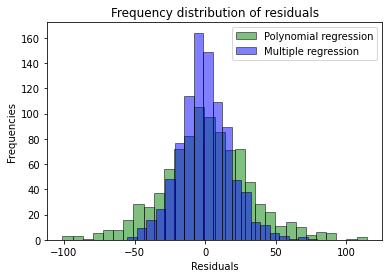

In [53]:
# Normality of residuals
resi_poly = hs - poly_pred
resi = hs - lr.predict(X)

# Graph 2.2 Histogram for residuals
plt.hist(resi_poly, bins=30, color='green', edgecolor='black', alpha=0.5, label='Polynomial regression')
plt.hist(resi, bins=20, color='blue', edgecolor='black', alpha=0.5, label='Multiple regression')
plt.legend()
plt.xlabel('Residuals')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of residuals')
plt.savefig('4.2 residuals.pdf')
plt.show()